In [13]:
import pandas as pd
import numpy as np
from __future__ import print_function
import sklearn
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import optuna
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance
import statsmodels.formula.api as smf
import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns



Le variabili Utilzzate nel dataset utilizzato sono le seguenti:
- age: etá del detenuto
- 'sex: sesso del detenuto
- priors count: Numero totale di reati precedenti
-'days_b_screening_arrest': Giorni trascorsi dal controllo all'arresto
- c_charge_degree: Grado del reato accusato
- race: razza del detenuto
- juv_fel_count: numero di reati gravi commessi in gioventu
- juv_misd_count: reati minori commessi in gioventu
- 'juv_other_count': numero di altri reati minori commessi in gioventu
-  'two_year_recid': variabile target, indica se c'é stata recidiva negli ultimi due anni
- Compas Score: indica la previsione effettuata dall'algoritmo, modello COMPAS



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        7214 non-null   int64  
 1   juv_fel_count              7214 non-null   int64  
 2   juv_misd_count             7214 non-null   int64  
 3   priors_count               7214 non-null   int64  
 4   days_b_screening_arrest    7214 non-null   float64
 5   recidivism_within_2_years  7214 non-null   int64  
 6   COMPASS_determination      7214 non-null   int32  
 7   African-American           7214 non-null   bool   
 8   Caucasian                  7214 non-null   bool   
 9   Hispanic                   7214 non-null   bool   
 10  Native American            7214 non-null   bool   
 11  Other                      7214 non-null   bool   
 12  Male                       7214 non-null   bool   
 13  F                          7214 non-null   bool 

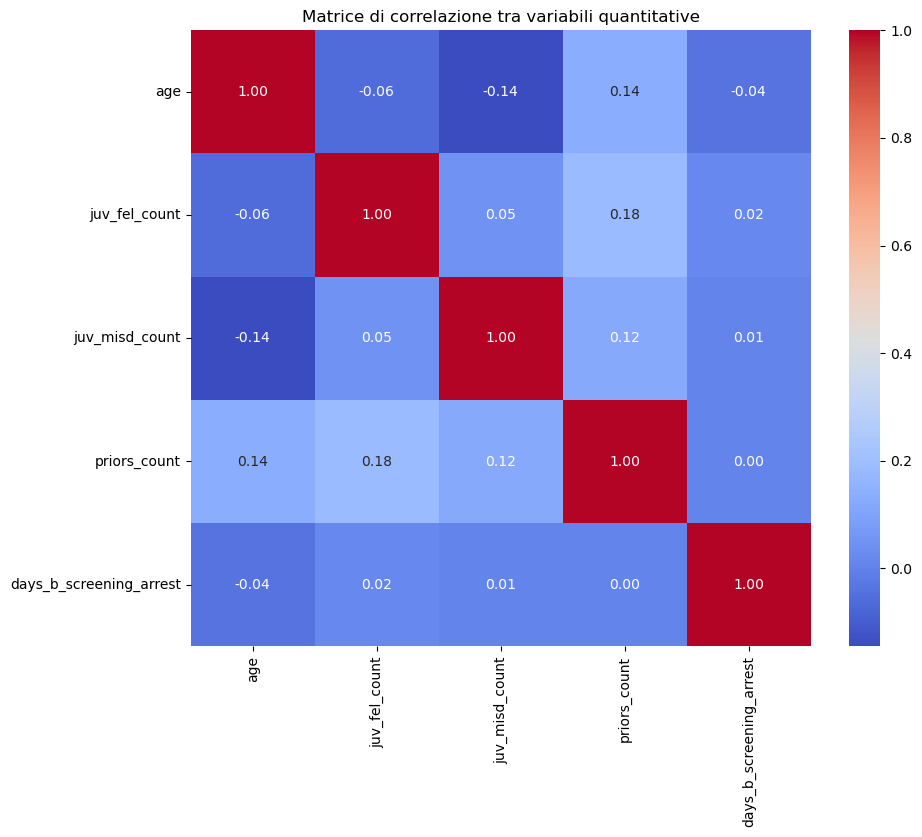

In [14]:
df2="archive\compas-scores-two-years.csv"
df = pd.read_csv(df2)

#Preprocessed
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]
df['recidivism_within_2_years'] = df['is_recid']
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)
dummy_variable = pd.get_dummies(df['race'])
df = pd.concat([df, dummy_variable], axis=1)
dummy_variable = pd.get_dummies(df['sex'])
df = pd.concat([df, dummy_variable], axis=1)
df['juv_misd_count']=df['juv_other_count']+df['juv_other_count']
media = df['days_b_screening_arrest'].mean()
df['days_b_screening_arrest'] = df['days_b_screening_arrest'].fillna(media)
input_features = ['Male', 'age', 'African-American', 'Caucasian',
                   'Hispanic', 'Native American', 'Other', 'priors_count', 'days_b_screening_arrest',
                   'c_charge_degree', 'juv_fel_count','juv_misd_count']
to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']
to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)
dummy_variable = pd.get_dummies(df['c_charge_degree'])
df = pd.concat([df, dummy_variable], axis=1)
input_columns = df.columns.tolist()
df = df.drop(columns=['c_charge_degree'])
df = df.drop(columns=['M'])
labels = df['COMPASS_determination']

print(df.info())

#Split in train and test


df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]
test_data_with_labels = df[train_size:]
class_names = ["no", "yes"]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_data_labels = test_data_with_labels['recidivism_within_2_years']

models = {} #trained models scores
best=0

numeric_df = train_data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()

# corrplot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di correlazione tra variabili quantitative')
plt.show()

In [15]:
#is it balanced?

conteggio_classi = df['recidivism_within_2_years'].value_counts()
print(conteggio_classi)


recidivism_within_2_years
0    3743
1    3471
Name: count, dtype: int64


Random Forest

In [16]:
def objective(trial):


    # Define hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 250)
    max_features = trial.suggest_int('max_features', 1, 100)
    max_depth = trial.suggest_int('max_depth', 1, 200)
    min_samples_split = trial.suggest_int('min_samples_split', 2,  30)
    # Method of selecting samples for training each tree
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    # Criterion
    criterion=trial.suggest_categorical('criterion', ['gini', 'entropy'])
    # Create and train the model
    rf_classifier = sklearn.ensemble.RandomForestClassifier(
       n_estimators=n_estimators, max_features=max_features,max_depth=max_depth,  min_samples_split=min_samples_split, bootstrap=bootstrap, criterion=criterion
    )
    rf_classifier.fit(train_data, train_labels)

    # Evaluate the model
    y_pred = rf_classifier.predict(test_data)
    f1 =  sklearn.metrics.f1_score(test_data_labels, y_pred, average='binary')

    return f1

# Esegui l'ottimizzazione
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Stampa i risultati migliori
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")





[I 2024-03-16 18:24:47,582] A new study created in memory with name: no-name-135df5c8-8465-4a06-9a57-cb0fa6fd3127
[I 2024-03-16 18:24:50,478] Trial 0 finished with value: 0.6127080181543118 and parameters: {'n_estimators': 243, 'max_features': 23, 'max_depth': 74, 'min_samples_split': 27, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6127080181543118.
[I 2024-03-16 18:24:51,908] Trial 1 finished with value: 0.6100151745068285 and parameters: {'n_estimators': 118, 'max_features': 28, 'max_depth': 71, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6127080181543118.
[I 2024-03-16 18:24:53,444] Trial 2 finished with value: 0.5986290936785987 and parameters: {'n_estimators': 112, 'max_features': 22, 'max_depth': 135, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6127080181543118.
[I 2024-03-16 18:24:54,744] Trial 3 finished with value: 0.6138763197586727 and p

Best trial:
Value:  0.649923896499239
Params: 
    n_estimators: 75
    max_features: 48
    max_depth: 144
    min_samples_split: 30
    bootstrap: True
    criterion: entropy


Random forest has achieved the top score! 0.6354009077155823


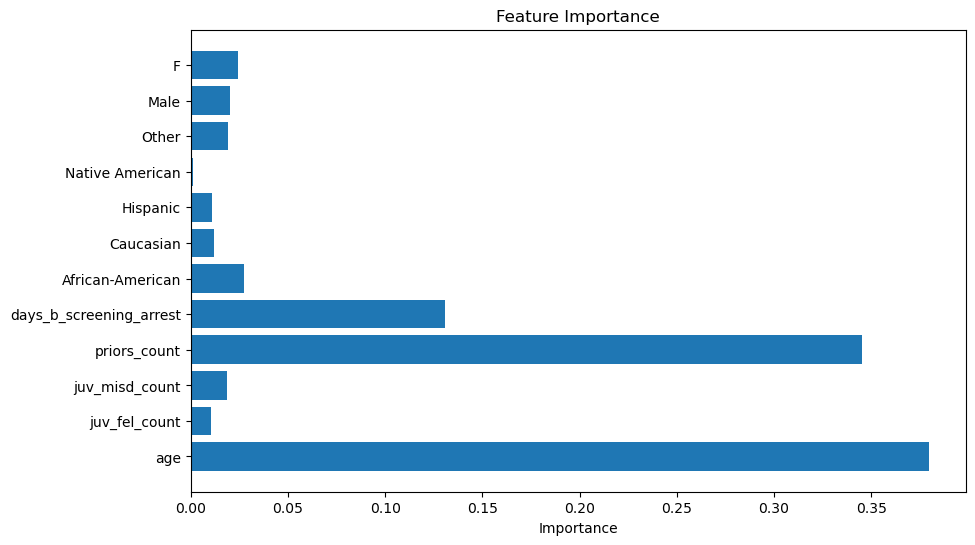

In [17]:

rf1= sklearn.ensemble.RandomForestClassifier(n_estimators=trial.params["n_estimators"], max_features= trial.params['max_features'], 
    max_depth = trial.params['max_depth'], min_samples_split= trial.params['min_samples_split'], bootstrap = trial.params[ 'bootstrap'], criterion = trial.params['criterion'])
    
rf1.fit(train_data, train_labels)
pred = rf1.predict(test_data)

score1 = sklearn.metrics.f1_score(test_data_labels, pred, average='binary')
models['Random Forest']=(score1, rf1)
if score1 > best:
    best = score1
    clf = "Random forest"
    print("Random forest has achieved the top score!", score1)
else:
    print("Score of random forest", score1)


pd.DataFrame(rf1.feature_importances_, index=train_data.columns).sort_values(by=0, ascending=False)

importances = rf1.feature_importances_

# Visualizzazione dell'importanza delle feature
plt.figure(figsize=(10, 6))
plt.barh(range(train_data.shape[1]), importances, align='center')
plt.yticks(np.arange(train_data.shape[1]), train_data.columns)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

We can see that African- American is the fourth variable in terms of trees importance

Random forest 2 has achieved the top score! 0.650566037735849


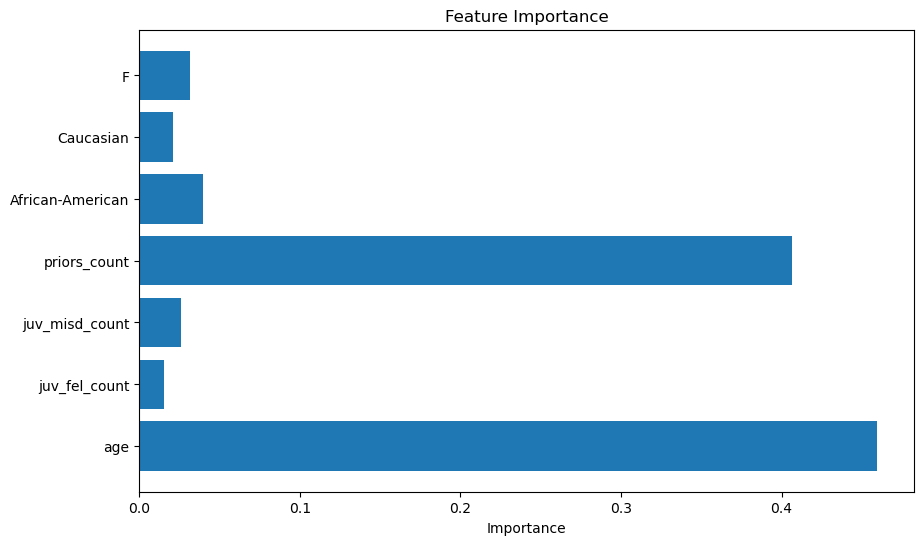

In [18]:
#Select most important features
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
selector = SelectKBest(score_func=f_classif, k=7)
selector.fit_transform(train_data, train_labels)
feature_mask = selector.get_support()
feature_names = train_data.columns[feature_mask]

#Second Random Forest with selected features

rf2= sklearn.ensemble.RandomForestClassifier(n_estimators=trial.params["n_estimators"], max_features= trial.params['max_features'], 
    max_depth = trial.params['max_depth'], min_samples_split= trial.params['min_samples_split'], bootstrap = trial.params[ 'bootstrap'], criterion = trial.params['criterion'])
    

rf2.fit(train_data[feature_names], train_labels)
pred = rf2.predict(test_data[feature_names])

score2 = sklearn.metrics.f1_score(test_data_labels, pred, average='binary')
models['Random Forest2']=(score2, rf2)
if score2 > best:
    best = score2
    clf = "Random forest"
    print("Random forest 2 has achieved the top score!", score2)
else:
    print("Score of random forest", score2)

importances = rf2.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(train_data[feature_names].shape[1]), importances, align='center')
plt.yticks(np.arange(train_data[feature_names].shape[1]), train_data[feature_names].columns)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Gradient Boosting Classifier

In [19]:


def objective(trial):
    # Define hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 250)
    max_features= trial.suggest_int('max_features', 1, 100),
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30),
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
    learning_rate =  trial.suggest_float('learning_rate', 0.01, 1.0),
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential']),
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50),
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
    subsample = trial.suggest_float('subsample', 0.5, 1.0),
    warm_start =  trial.suggest_categorical('warm_start', [True, False])
    # Create and train the model
    gb_classifier = GradientBoostingClassifier(
       n_estimators = n_estimators,
        max_features = max_features[0],
        min_samples_split = min_samples_split[0],
        criterion = criterion,
        learning_rate = learning_rate[0],
        loss = loss[0],
        max_leaf_nodes = max_leaf_nodes[0],
        
        min_weight_fraction_leaf = min_weight_fraction_leaf[0],
        subsample = subsample[0],
        warm_start = warm_start

    )
    gb_classifier.fit(train_data, train_labels)

    # Evaluate the model
    y_pred = gb_classifier.predict(test_data)
    f1 =  sklearn.metrics.f1_score(test_data_labels, y_pred, average='binary')

    return f1

# Esegui l'ottimizzazione
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Stampa i risultati migliori
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-16 18:25:39,744] A new study created in memory with name: no-name-17ee3fbc-bb8c-480f-b15c-733074cf78c3
[I 2024-03-16 18:25:39,928] Trial 0 finished with value: 0.6536388140161724 and parameters: {'n_estimators': 109, 'max_features': 20, 'min_samples_split': 20, 'criterion': 'squared_error', 'learning_rate': 0.6470489988376317, 'loss': 'log_loss', 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.4765918096849754, 'subsample': 0.9853538774194507, 'warm_start': False}. Best is trial 0 with value: 0.6536388140161724.
[I 2024-03-16 18:25:39,987] Trial 1 finished with value: 0.6574545454545454 and parameters: {'n_estimators': 26, 'max_features': 54, 'min_samples_split': 5, 'criterion': 'squared_error', 'learning_rate': 0.843924536148864, 'loss': 'log_loss', 'max_leaf_nodes': 47, 'min_weight_fraction_leaf': 0.10090150441997647, 'subsample': 0.5063524674374291, 'warm_start': True}. Best is trial 1 with value: 0.6574545454545454.
[I 2024-03-16 18:25:40,178] Trial 2 finished with v

Best trial:
Value:  0.6666666666666667
Params: 
    n_estimators: 60
    max_features: 32
    min_samples_split: 27
    criterion: squared_error
    learning_rate: 0.9460376269650878
    loss: exponential
    max_leaf_nodes: 35
    min_weight_fraction_leaf: 0.41586958435201
    subsample: 0.957201594675021
    warm_start: False


In [20]:
#Gradient boosting classifier
gb1 = GradientBoostingClassifier(random_state=1, n_estimators = trial.params['n_estimators'],
max_features = trial.params['max_features'],
min_samples_split = trial.params['min_samples_split'],
criterion = trial.params['criterion'],
learning_rate = trial.params['learning_rate'],
loss = trial.params['loss'],
max_leaf_nodes = trial.params['max_leaf_nodes'],
min_weight_fraction_leaf = trial.params['min_weight_fraction_leaf'],
subsample = trial.params['subsample'],
warm_start = trial.params['warm_start'])
gb1.fit(train_data, train_labels)
pred = gb1.predict(test_data)


score4 = sklearn.metrics.f1_score(test_data_labels, pred, average='binary')
models['Gradient Boosting Class']=(score4, gb1)
if score4 > best:
    best = score4
    clf = "Gradient boosting"
    print("Gradient boosting has achieved the top score!", score4)
else:
    print("Score of gradient boosting", score4)

Gradient boosting has achieved the top score! 0.6666666666666667


Decision Tree

In [21]:
#! pip install optuna
def objective(trial):
    # Define hyperparameters
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features= trial.suggest_int('max_features', 1, 100),
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30),
    criterion = trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50),
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 1.0)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
    # Create and train the model
    dt_classifier = DecisionTreeClassifier(
        max_features = max_features[0],
        min_samples_split = min_samples_split[0],
        criterion = criterion,
        max_leaf_nodes = max_leaf_nodes[0],
        splitter = splitter,
        max_depth = max_depth,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        min_weight_fraction_leaf=min_weight_fraction_leaf[0],
   

    )
    # Create and train the model

    dt_classifier.fit(train_data, train_labels)

    # Evaluate the model
    y_pred = dt_classifier.predict(test_data)
    f1 =  sklearn.metrics.f1_score(test_data_labels, y_pred, average='binary')

    return f1

# Esegui l'ottimizzazione
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Stampa i risultati migliori
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-16 18:25:50,264] A new study created in memory with name: no-name-a494a158-0518-48b8-831e-d47de861c00e
[I 2024-03-16 18:25:50,281] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 31, 'splitter': 'best', 'criterion': 'log_loss', 'max_leaf_nodes': 45, 'min_impurity_decrease': 0.14428757334814046, 'min_weight_fraction_leaf': 0.2477538376324534}. Best is trial 0 with value: 0.0.
[I 2024-03-16 18:25:50,290] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 64, 'splitter': 'best', 'criterion': 'gini', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.8066128390600525, 'min_weight_fraction_leaf': 0.11176231880466131}. Best is trial 0 with value: 0.0.
[I 2024-03-16 18:25:50,298] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 12, 'splitter': 'r

Best trial:
Value:  0.6652298850574713
Params: 
    max_depth: 29
    min_samples_split: 4
    min_samples_leaf: 15
    max_features: 28
    splitter: best
    criterion: gini
    max_leaf_nodes: 46
    min_impurity_decrease: 5.16382471358926e-05
    min_weight_fraction_leaf: 0.02774562084250747


In [17]:

dt1 = DecisionTreeClassifier(max_features = trial.params['max_features'],
min_samples_split = trial.params['min_samples_split'],
criterion = trial.params['criterion'],
max_leaf_nodes = trial.params['max_leaf_nodes'],
splitter = trial.params['splitter'],
max_depth = trial.params['max_depth'],
min_samples_leaf = trial.params['min_samples_leaf'],
min_impurity_decrease = trial.params['min_impurity_decrease'],
min_weight_fraction_leaf = trial.params['min_weight_fraction_leaf'], random_state=42)


#Pruning
ccp_alphas = dt1.cost_complexity_pruning_path(train_data,train_labels)['ccp_alphas']
parameters = {'ccp_alpha':ccp_alphas.tolist()}
gsearch = GridSearchCV(dt1, parameters, cv=10)
print(ccp_alphas.tolist())

# step 3: conduct grid search over the parameter space
gsearch.fit(train_data,train_labels)
dt1_pruned = gsearch.best_estimator_

dt1_pruned.fit(train_data, train_labels)
pred = dt1_pruned.predict(test_data)
score7 = sklearn.metrics.f1_score(test_data_labels, pred, average='binary')
models['Decision Tree']=(score7, dt1_pruned)
if score7 > best:
    best = score7
    clf = "Decision tree"
    print("Decision tree has achieved the top score!", score7)
else:
    print("Score of decision tree", score7)

Score of decision tree 0.6551724137931034


|--- priors_count <= 4.50
|   |--- age <= 27.50
|   |   |--- class: 1
|   |--- age >  27.50
|   |   |--- class: 0
|--- priors_count >  4.50
|   |--- class: 1



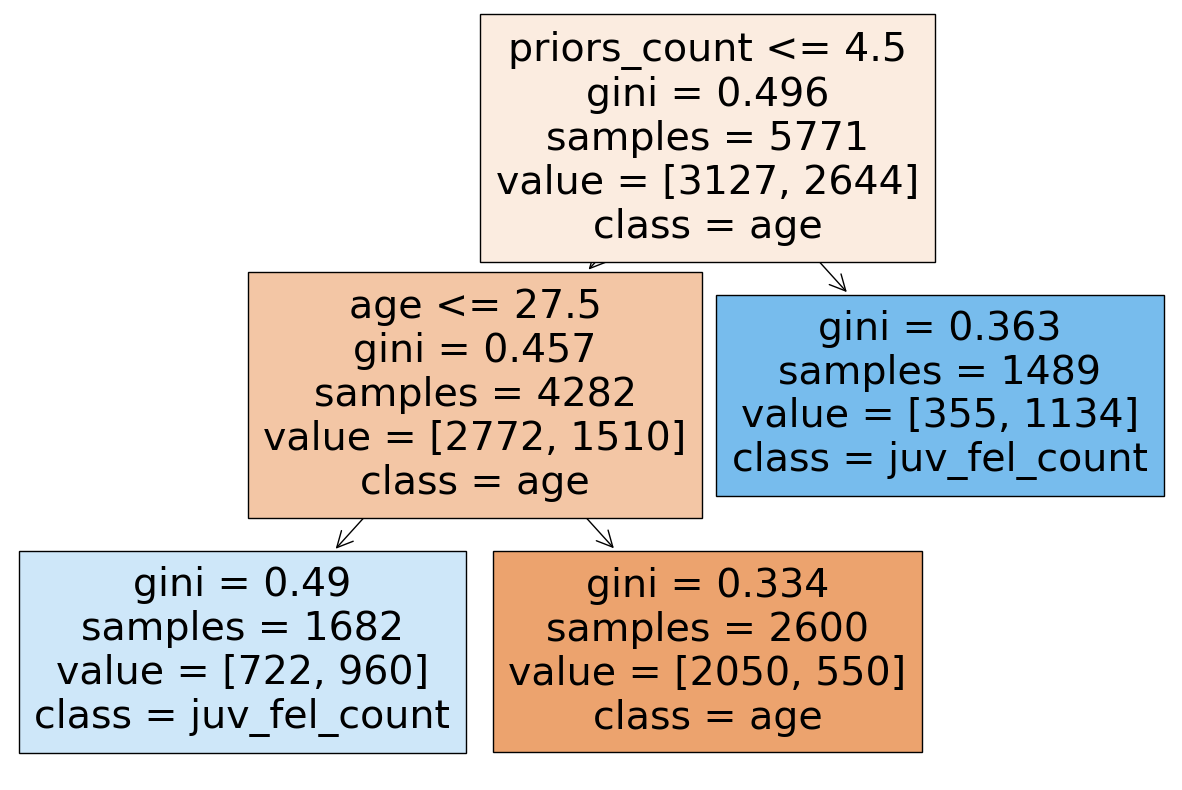

In [18]:

tree_text = export_text(dt1, feature_names=train_data.columns)
print(tree_text)

# Visualizza l'albero decisionale
plt.figure(figsize=(15, 10))  # Imposta le dimensioni della figura
plot_tree(dt1, feature_names=list(train_data.columns), class_names=list(train_data.columns), filled=True)  # Plot dell'albero
plt.show()

Text(0.5, 0, 'Decision Tree Feature Importance')

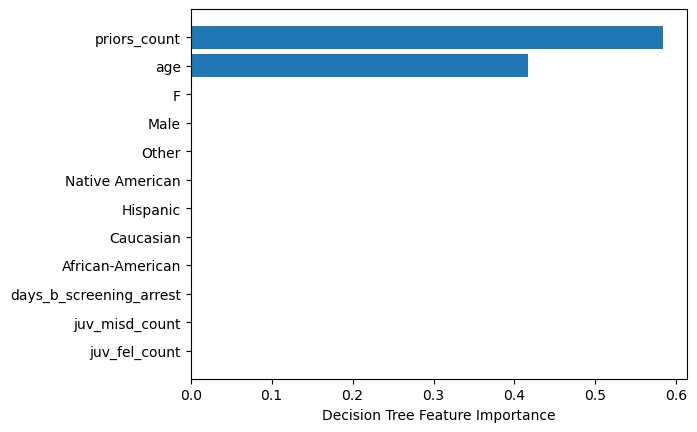

In [19]:
# Show the feature importance scores on the bar graph
sorted_idx = dt1.feature_importances_.argsort()
features_list = train_data.columns.values
plt.barh(features_list[sorted_idx], dt1.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")

Text(0.5, 0, 'Decision Tree Permutation Importance')

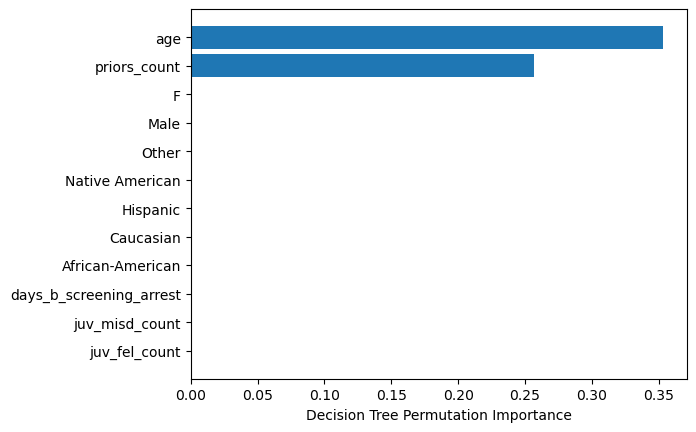

In [20]:

# Permutation feature importance scores for each feature
perm_importance = permutation_importance(dt1, test_data, pred)
# Show the permutation feature importance scores on the bar graph
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(test_data.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Decision Tree Permutation Importance")

Logistic Regression

In [21]:
train = train_data.join(train_labels)
train = train.rename(columns={'Native American': 'Native_American', 'African-American': 'African_American'})
test = test_data.join(test_data_labels)
test = test.rename(columns={'Native American': 'Native_American', 'African-American': 'African_American'})
log_model = smf.logit(formula='COMPASS_determination ~ ' + " + ".join(train.columns.difference(['COMPASS_determination'])), data=train).fit()
pprint.pprint(log_model.summary())
y_pred_prob = log_model.predict(test.drop(columns=['recidivism_within_2_years']))
y_pred = list(map(round, y_pred_prob)) 

Optimization terminated successfully.
         Current function value: 0.500832
         Iterations 7
<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
Dep. Variable:     COMPASS_determination   No. Observations:                 5771
Model:                             Logit   Df Residuals:                     5758
Method:                              MLE   Df Model:                           12
Date:                   Sat, 16 Mar 2024   Pseudo R-squ.:                  0.2738
Time:                           17:04:50   Log-Likelihood:                -2890.3
converged:                          True   LL-Null:                       -3979.9
Covariance Type:               nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercep

In [22]:

coefficients = log_model.params
ttest= log_model.pvalues
coefficients_exp = np.exp(coefficients)


coef = pd.DataFrame({'Coefficients': coefficients_exp, 'P-values': ttest})
alpha_values = [0.5, 0.01, 0.001]
significance_labels = ['*', '**', '***']
for id, row in coef.iterrows():
    for alpha, label in zip(alpha_values, significance_labels):
        if row['P-values'] < alpha:
            coef.at[id, 'significance'] = label
  


print(coef)
#AIC
aic = log_model.aic
print(aic)
score9 = sklearn.metrics.f1_score(test_data_labels, y_pred, average='binary')
models['Logistic Regression 1']= (score9, log_model)
print(score9)

                          Coefficients       P-values significance
Intercept                     4.584876   3.055751e-03           **
African_American[T.True]      1.724322   2.708291e-01            *
Caucasian[T.True]             1.105387   8.398432e-01          NaN
F[T.True]                     1.427508   2.068812e-07          ***
Hispanic[T.True]              0.837507   7.256734e-01          NaN
Male[T.True]                  0.796139   4.976085e-03           **
Native_American[T.True]       1.761526   4.869918e-01            *
Other[T.True]                 0.550008   2.468884e-01            *
age                           0.915334  7.557223e-126          ***
days_b_screening_arrest       1.000345   4.009220e-01            *
juv_fel_count                 1.429277   1.730562e-02            *
juv_misd_count                1.199359   1.390069e-04          ***
priors_count                  1.336467  7.667607e-140          ***
5806.597582706501
0.6613021214337967


In [23]:
log_model_2 = smf.logit(formula='COMPASS_determination ~ ' + " + ".join(train.columns.difference(['COMPASS_determination', 'Hispanic', 'Caucasian'])), data=train).fit()
coefficients = log_model_2.params
ttest= log_model_2.pvalues
coefficients_exp = np.exp(coefficients)


coef = pd.DataFrame({'Coefficients': coefficients_exp, 'P-values': ttest})
alpha_values = [0.5, 0.01, 0.001]
significance_labels = ['*', '**', '***']
for id, row in coef.iterrows():
    for alpha, label in zip(alpha_values, significance_labels):
        if row['P-values'] < alpha:
            coef.at[id, 'significance'] = label
  


print(coef)
#AIC
aic = log_model_2.aic
print(aic)

# Evaluate the model

y_pred_prob_2 = log_model_2.predict(test.drop(columns=['recidivism_within_2_years']))
y_pred_2 = list(map(round, y_pred_prob_2)) 
score10 = sklearn.metrics.f1_score(test_data_labels, y_pred_2, average='binary')
models['Logistic Regression 2']= (score10, log_model_2)
print(score10)

Optimization terminated successfully.
         Current function value: 0.501257
         Iterations 7
                          Coefficients       P-values significance
Intercept                     4.770715   6.758187e-27          ***
African_American[T.True]      1.652040   6.284774e-14          ***
F[T.True]                     1.431147   1.642694e-07          ***
Male[T.True]                  0.787577   3.198304e-03           **
Native_American[T.True]       1.686923   4.214821e-01            *
Other[T.True]                 0.527368   7.964174e-05          ***
age                           0.915593  2.791600e-125          ***
days_b_screening_arrest       1.000347   3.983122e-01            *
juv_fel_count                 1.420173   1.874632e-02            *
juv_misd_count                1.202968   1.073400e-04          ***
priors_count                  1.336990  3.848773e-140          ***
5807.512551960755
0.6607929515418502


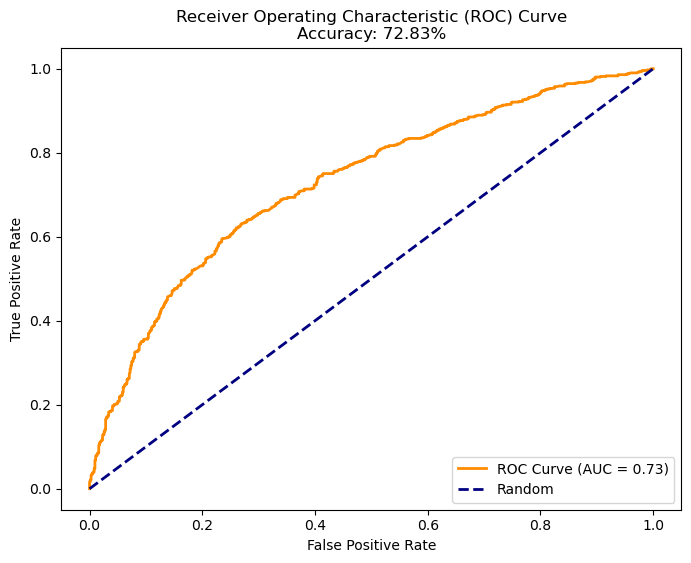

In [24]:
#Roc Curve. auc computatio
fpr, tpr, thresholds = roc_curve(test_data_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    roc_auc * 100))
plt.legend(loc="lower right")
plt.show()

F1 score using SFS 0.6564327485380117


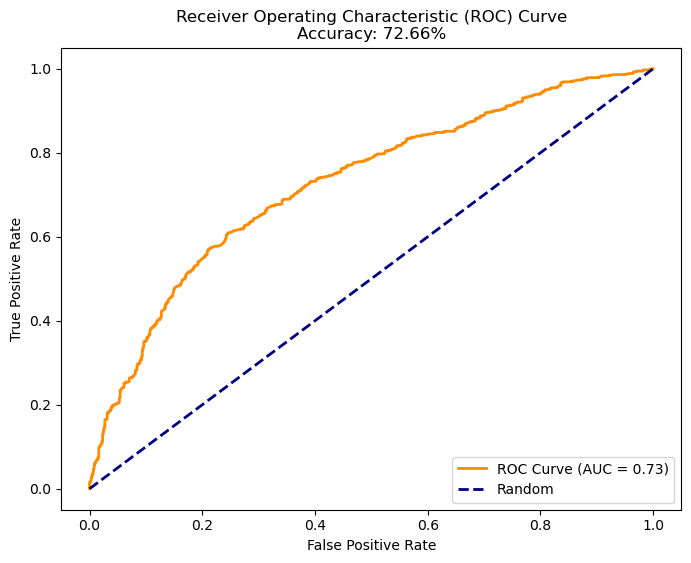

In [26]:
#Step Whise features selection
lr = LogisticRegression()
sfs = SequentialFeatureSelector(lr, n_features_to_select=7, direction='backward', cv=5)
sfs.fit(train_data, train_labels)
feature_idx = sfs.get_support(indices=True)
print(sfs.__getattribute__)
print("Selected feature indices:", feature_idx)

X_train_sfs = train_data.iloc[:, feature_idx]
X_test_sfs = test_data.iloc[:, feature_idx]

log_r_sfs = LogisticRegression()
log_r_sfs.fit(X_train_sfs, train_labels)
y_pred = log_r_sfs.predict(X_test_sfs)
y_pred_prob = log_r_sfs.predict_proba(X_test_sfs)

#F1
score11 = sklearn.metrics.f1_score(test_data_labels, y_pred, average='binary')
models['Logistic Regression 3']= (score11, log_r_sfs)
print("F1 score using SFS", score11)


fpr, tpr, thresholds = roc_curve(test_data_labels, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    roc_auc * 100))
plt.legend(loc="lower right")
plt.show()

SVM

In [7]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(train_data, train_labels) 
grid_pred = grid.predict(test_data)
score13 = sklearn.metrics.f1_score(test_data_labels, grid_pred, average='binary')
models['SVM']=(score13, grid)
print(score13)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.562 total time=   1.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.559 total time=   1.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.562 total time=   1.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.561 total time=   1.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.560 total time=   1.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.729 total time=   0.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.737 total time=   0.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.681 total time=   0.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.711 total time=   0.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.739 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [27]:
max_model = max(models.values(), key=lambda x: x[0])

from joblib import dump

# Salvataggio del modello
dump(rf1, 'modello.joblib')

(0.6666666666666667, GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.9460376269650878, loss='exponential',
                           max_features=32, max_leaf_nodes=35,
                           min_samples_split=27,
                           min_weight_fraction_leaf=0.41586958435201,
                           n_estimators=60, random_state=1,
                           subsample=0.957201594675021))


['modello.joblib']